In [104]:
from elasticsearch_dsl import connections, A, Index, analyzer, DocType, Date, Text, Keyword, Search, Nested, InnerDoc
from elasticsearch_dsl.analysis import TokenFilter
import json
import pprint
import os
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# in case of problsems with "only allow delete api" then:
# curl -XPUT -H "Content-Type: application/json" http://localhost:9200/_all/_settings -d '{"index.blocks.read_only_allow_delete": null}'

Defines a default connection that will be used globally

In [4]:
connections.create_connection(hosts=['localhost'], timeout=20) 

<Elasticsearch([{'host': 'localhost'}])>

Defines an index

In [5]:
judgments = Index(name = 'judgments')

In [6]:
# TODO: resolve what should be datatype for judges
class Judge(InnerDoc):
    function = Text()
    name = Text(fielddata=True)
    specialRoles = Text()


class Judgments(DocType):
    content = Text()
    date = Date()
    title = Keyword()
    judges = Nested(Judge)
    
    class Meta:
        index = 'title'
    
    def add_judge(self, function, name, specialRoles):
        self.judges.append(
            Judge(function=function, name=name, specialRoles=specialRoles))
    

In [7]:
judgments.doc_type(Judgments)

__main__.Judgments

In [8]:
default_analyzer = analyzer('default_analyzer',
                           tokenizer='standard')

In [9]:
morfologik_analyzer = analyzer('morfologik', tokenizer='standard', filter='morfologik_stem')

In [10]:
judgments.analyzer(default_analyzer)
# judgments.analyzer(morfologik_analyzer)

In [11]:
judgments.delete(ignore=404)
judgments.create()

In [12]:
def read_file(file_path):
    with open (file_path) as file:
        json_content = json.load(file)
        for judgment in json_content:
            content = judgment['textContent']
            date = judgment['judgmentDate']
            title = judgment['courtCases'][0]['caseNumber']
            judges  = judgment['judges']
            # pprint.pprint(judges)
            maping = Judgments(content=content, date=date, title=title)
            for judge in judges:
                maping.add_judge(function=judge['function'], 
                             name=judge['name'], 
                             specialRoles=judge['specialRoles'])
                maping.save()

In [13]:
def read_all_judgments_from_2018():
    for filename in os.listdir("../data_filtered/"):
        read_file("../data_filtered/" + filename)

In [14]:
read_all_judgments_from_2018()

In [15]:
query = Search().query("match", content="szkoda")
response = query.execute(ignore_cache=True)
print (query.to_dict())

print (f"Liczba orzeczen w ktorych wystepuje slowo szkoda wynosi: {query.count()}")

{'query': {'match': {'content': 'szkoda'}}}
Liczba orzeczen w ktorych wystepuje slowo szkoda wynosi: 1143


In [16]:
# https://github.com/elastic/elasticsearch-dsl-py/issues/294
# Znajdź liczbę orzeczeń, w których występuje fraza trwały uszczerbek na zdrowiu, 
# dokładnie w tej kolejności ale w dowolnej formie fleksyjnej.
judgments.close()
judgments.analyzer(morfologik_analyzer)
judgments.open()

{'acknowledged': True, 'shards_acknowledged': True}

In [17]:
query = Search().query("match_phrase", content="trwały uszczerbek na zdrowiu")
response = query.execute(ignore_cache=True)
print (query.to_dict())

print (f"Liczba orzeczen w ktorych wystepuje trwały uczerbek na zdrowiu i jego odmiany fleksyjne wynosi: {query.count()}")

{'query': {'match_phrase': {'content': 'trwały uszczerbek na zdrowiu'}}}
Liczba orzeczen w ktorych wystepuje trwały uczerbek na zdrowiu i jego odmiany fleksyjne wynosi: 123


In [18]:
slop = 2

search = Search().from_dict({"query": {
      "match_phrase": {
         "content": {
            "query": "trwały uszczerbek na zdrowiu",
            "slop": slop
         }
      }
   }})

response = search.execute()
print (search.to_dict())
print (f"Liczba orzeczen w ktorych wystepuje trwały uczerbek na zdrowiu (wraz z odmianami fleksyjnymi) dla slop={slop}: {search.count()}")

{'query': {'match_phrase': {'content': {'query': 'trwały uszczerbek na zdrowiu', 'slop': 2}}}}
Liczba orzeczen w ktorych wystepuje trwały uczerbek na zdrowiu (wraz z odmianami fleksyjnymi) dla slop=2: 140


In [19]:
search = Search().from_dict(
{
   "size": 0,
       "aggs": {
            "judges_name": {
               "terms": {
                  "field": "judges.name.keyword",
                   "size": 3
               }
            }
   }
})
response = search.execute()
pprint.pprint (response.to_dict())

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 15, 'total': 15},
 'aggregations': {'judges_name': {'buckets': [{'doc_count': 308,
                                               'key': 'Barbara '
                                                      'Orechwa-Zawadzka'},
                                              {'doc_count': 238,
                                               'key': 'Alicja Sołowińska'},
                                              {'doc_count': 238,
                                               'key': 'B. Kempa'}],
                                  'doc_count_error_upper_bound': 165,
                                  'sum_other_doc_count': 19177}},
 'hits': {'hits': [], 'max_score': 0.0, 'total': 15734},
 'timed_out': False,
 'took': 255}


[{'key_as_string': '2018-01-01T00:00:00.000Z', 'key': 1514764800000, 'doc_count': 14169}, {'key_as_string': '2018-02-01T00:00:00.000Z', 'key': 1517443200000, 'doc_count': 1578}]


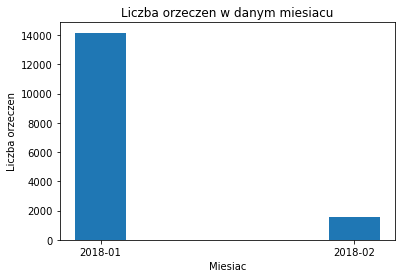

In [112]:
search = Search().from_dict(
{
    "size": 0,
    "aggs" : {
        "judges_over_time" : {
            "date_histogram" : {
                "field" : "date",
                "interval" : "month"
            }
        }
    }
})

response = search.execute()
buckets = response.aggregations.judges_over_time.buckets
pprint.pprint (buckets)
counts = [bucket.doc_count for bucket in buckets]

dates = [bucket.key_as_string[:7] for bucket in buckets]

fig, ax = plt.subplots()
plt.bar([0,1], height=counts, width=0.2)

ax.set_xticks(np.arange(0, 2))
ax.set_xticklabels(dates)
plt.xlabel('Miesiac')
plt.ylabel('Liczba orzeczen')
plt.title('Liczba orzeczen w danym miesiacu')
plt.grid(False)
plt.show()

[{'key_as_string': '2018-01-01T00:00:00.000Z', 'key': 1514764800000, 'doc_count': 1908}, {'key_as_string': '2018-01-08T00:00:00.000Z', 'key': 1515369600000, 'doc_count': 4106}, {'key_as_string': '2018-01-15T00:00:00.000Z', 'key': 1515974400000, 'doc_count': 4050}, {'key_as_string': '2018-01-22T00:00:00.000Z', 'key': 1516579200000, 'doc_count': 2876}, {'key_as_string': '2018-01-29T00:00:00.000Z', 'key': 1517184000000, 'doc_count': 1727}, {'key_as_string': '2018-02-05T00:00:00.000Z', 'key': 1517788800000, 'doc_count': 698}, {'key_as_string': '2018-02-12T00:00:00.000Z', 'key': 1518393600000, 'doc_count': 309}, {'key_as_string': '2018-02-19T00:00:00.000Z', 'key': 1518998400000, 'doc_count': 73}]
[{'key_as_string': '2018-01-01T00:00:00.000Z', 'key': 1514764800000, 'doc_count': 1908}, {'key_as_string': '2018-01-08T00:00:00.000Z', 'key': 1515369600000, 'doc_count': 4106}, {'key_as_string': '2018-01-15T00:00:00.000Z', 'key': 1515974400000, 'doc_count': 4050}, {'key_as_string': '2018-01-22T00:0

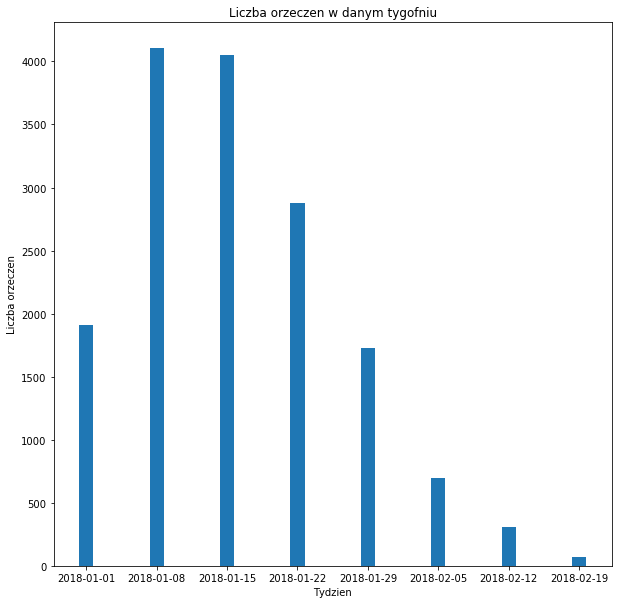

In [120]:
search = Search().from_dict({
    "size": 0,
    "aggs" : {
        "judges_over_time" : {
            "date_histogram" : {
                "field" : "date",
                "interval" : "week"
            }
        }
    }
})

response = search.execute()
buckets = response.aggregations.judges_over_time.buckets
pprint.pprint (buckets)

pprint.pprint (buckets)
counts = [bucket.doc_count for bucket in buckets]

dates = [bucket.key_as_string[:10] for bucket in buckets]

fig, ax = plt.subplots()
plt.bar(np.arange(0, len(dates)), height=counts, width=0.2)

fig.set_size_inches(10, 10)

ax.set_xticks(np.arange(0, len(dates)))
ax.set_xticklabels(dates)
plt.xscale
plt.xlabel('Tydzien')
plt.ylabel('Liczba orzeczen')
plt.title('Liczba orzeczen w danym tygodniu')
plt.grid(False)
plt.show()